# Análise de Dados Tropicalias

#### Objetivo: Treinar uma IA para determinar se uma pessoa é um cliente em potencial ou não


##### Importações

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from random import randint
from math import sqrt

# A escolha da semente para a separação treino-teste foi inicialmente feita de maneira aleatoria, porém, após encontrar uma seed com resultados satisfatorios eu escolhi manualmente essa seed.
# rseed = randint(1,1000000000)
rseed = 517398857

pd.options.plotting.backend = "plotly"

os.environ["PATH"] += os.pathsep + "C:\\Users\\felipemiotto-ieg\\windows_10_msbuild_Release_graphviz-11.0.0-win32\\Graphviz\\bin"

df = pd.read_excel("Pesquisa clientes tropicálias.xlsx")

display(df.head(5))

,Qual é seu nome completo?,Qual é seu genero?,Qual é a sua idade?,Qual é a média da sua renda familiar mensal?,Qual estado você mora?,Qual cidade você mora?,Você usa muitos eletrônicos durante o dia? (6h ou mais),Qual grau de educação você tem?,Você pratica esportes? (pelo menos 3 vezes na semana),"Você frequenta muito espaços públicos? (parques, museus e etc)",Você gosta de arte?
0,Elizabete Silva,Feminino,43,Maior que R$ 2400 e menor que R$4000,SP,Barueri,v,Ensino médio,f,v,um pouco
1,rodrigo sotano almeida davila,Masculino,38,Maior que R$15000,SP,Barueri,v,Pós graduação,f,v,sim
2,Matilde de Bona Santana Brandão,Feminino,53,Maior que R$4000 e menor que R$6500,SP,Barueri,v,Ensino médio,v,v,um pouco
3,Bruna dias,Feminino,28,Maior que R$8500 e menor que R$11000,SP,Barueri,v,Pós graduação,v,f,um pouco
4,eduardo moraes de paula,Masculino,16,Menor ou igual à R$2400,SP,Barueri,v,Ensino médio,f,f,não


## Analise dos dados brutos

## Tratamento da base de dados

In [132]:
#Exclui a coluna de nome pois ela seria irrelevante para nossa IA e também exclui a coluna de cidade pois ela estava "atrapalhando" ao invés de ajudar.
df = df.drop(["Qual é seu nome completo?","Qual cidade você mora?"],axis=1)


# Durante a pesquisa os usuários poderiam responder que “gostam de arte”, “não gostam de arte” ou “gostam um pouco de arte”, porém, durante o tratamento de dados transformamos todas as respostas “um pouco” para “nao”, isso se deve pelo fato de que as pessoas normalmente nunca diriam que não gostam de arte, todos gostam em algum grau e algumas pessoas teriam vergonha de dizer que não gostavam de arte, por isso, deixamos as opções “um pouco” e “não” para atender as pessoas que não gostam muito de arte, mas, durante o tratamento de dados transformamos as respostas “um pouco” em “nao” pois assim conseguiremos definir melhor aqueles que gostam muito de arte (o público que buscamos).
# Trocando as respostas de "um pouco" por "nao"
df['Você gosta de arte?'] = df['Você gosta de arte?'].replace(to_replace='um pouco',value='nao')
df['Você gosta de arte?'] = df['Você gosta de arte?'].replace(to_replace='não',value='nao')
df = df.sort_values(by='Você gosta de arte?', ascending=False)

#Separação X e Y
y = pd.DataFrame(df["Você gosta de arte?"])
atributos = df.drop(["Você gosta de arte?"],axis=1)

In [133]:

#Transformando todas as colunas utilizando o encoder
lb = LabelEncoder()

#Nós aplicaremos o OrdinalEncoder em todas as colunas não numericas, já que, isso é necessario
preprocessador = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool']))
    ],
    remainder='passthrough',
    verbose_feature_names_out= False
)

#O codigo a seguir serve para conseguirmos testar a melhor combinação de encoders juntamente dos outros paremetros testados no GridSearchCV, assim, poderemos testar mais eficientemente todas as possibilidades.
class ScalerSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X, y=None):
        return self.scaler.fit(X)

    def transform(self, X, y=None):
        return self.scaler.transform(X)

my_scaler = ScalerSelector()

pre1 = ColumnTransformer(transformers = [
    ('num', my_scaler,atributos.columns.to_list())])



#Transformando a coluna y com LabelEncoder
y = lb.fit_transform(y)
display(y)

#Aplicando o OdinalEncoder nas colunas não numericas
x = pd.DataFrame(preprocessador.fit_transform(atributos),columns=preprocessador.get_feature_names_out())


#após usar o ordinal encoder a ordem das colunas é alterada
#voltando para a ordem antiga
colunas_originais = atributos.columns
x = x[colunas_originais]
display(x.head(5))

#aplicando tecnicas de oversampling
smote = SMOTE()
x, y = smote.fit_resample(x,y)

#divisão treino-teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y,test_size=0.2, random_state=rseed)

#escolha da metrica de avaliação
metrica = 'f1'
metricatxt = 'f1 score'

c:\Users\felipemiotto-ieg\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

,Qual é seu genero?,Qual é a sua idade?,Qual é a média da sua renda familiar mensal?,Qual estado você mora?,Você usa muitos eletrônicos durante o dia? (6h ou mais),Qual grau de educação você tem?,Você pratica esportes? (pelo menos 3 vezes na semana),"Você frequenta muito espaços públicos? (parques, museus e etc)"
0,0.0,30.0,5.0,11.0,1.0,2.0,0.0,1.0
1,1.0,15.0,5.0,11.0,1.0,5.0,1.0,0.0
2,1.0,27.0,1.0,11.0,1.0,4.0,0.0,1.0
3,0.0,74.0,1.0,11.0,1.0,2.0,0.0,0.0
4,1.0,33.0,1.0,11.0,1.0,2.0,1.0,0.0


## Treinando modelo com Naive Bayes

In [134]:
#treinando modelo com Naive bayes e analisando métricas resultantes
pipeline = Pipeline([
    ('pre1',pre1),
    ('dim',PCA()),
    ('model',GaussianNB())])


params_pipe = {
    'pre1__num__scaler': [StandardScaler(), MinMaxScaler()],
    'dim__n_components' : [1,2,3,4,5,6,7,None],
}


grid = GridSearchCV(estimator=pipeline,param_grid = params_pipe, n_jobs=-1, scoring=metrica)

grid.fit(x_treino,y_treino)



#mostrando melhores parametros, classification report e recall do modelo, prestando atenção especialmente no recall pois é o mais vantajoso para nosso caso
melhor = grid.best_params_
classificador_grafico = grid.best_estimator_ 
print("Melhores parametros: ",melhor)
print("Melhor ",metricatxt,": ",grid.best_score_)
previsao = classificador_grafico.predict(x_teste)
temp3 = classification_report(y_teste,previsao)
print(temp3)

Melhores parametros:  {'dim__n_components': 2, 'pre1__num__scaler': MinMaxScaler()}
Melhor  f1 score :  0.6349025974025974
              precision    recall  f1-score   support

           0       0.58      0.73      0.65        15
           1       0.80      0.67      0.73        24

    accuracy                           0.69        39
   macro avg       0.69      0.70      0.69        39
weighted avg       0.71      0.69      0.70        39



Media  f1 score em todos os testes:  0.5734107426583435


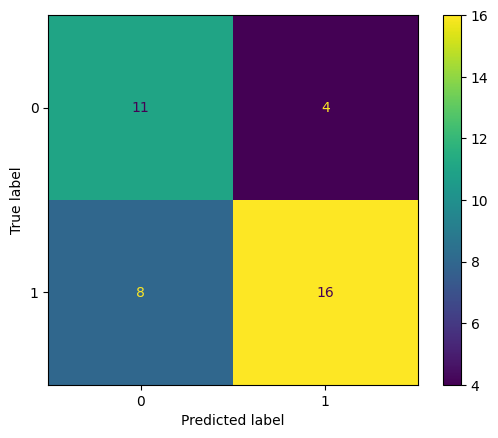

In [135]:
#media das pontuações de todos os cv
print("Media ",metricatxt, "em todos os testes: ",grid.cv_results_['mean_test_score'].mean())

#mostrando matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_teste, previsao), display_labels = [0, 1])
cm_display.plot()
plt.show()

roc_auc_score em NaiveBayes:  0.7000000000000001


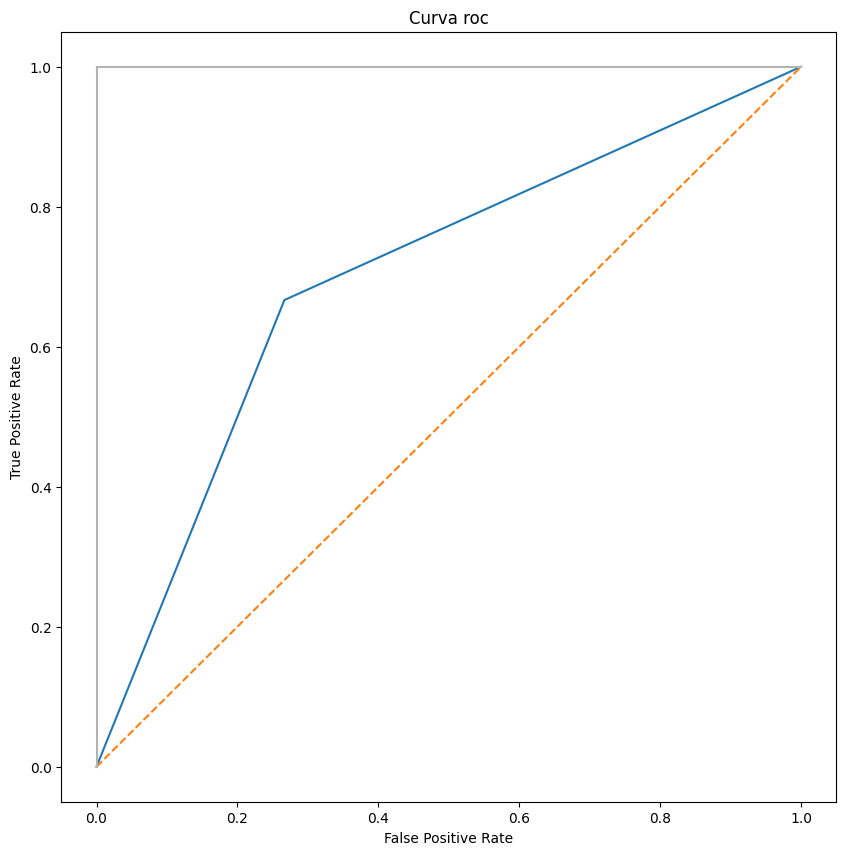

In [136]:
#mostrando o ROC score e a corva ROC

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, previsao)
print('roc_auc_score em NaiveBayes: ', roc_auc_score(y_teste, previsao))
plt.subplots(1, figsize=(10,10))
plt.title('Curva roc')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Treinando modelo com KNN

In [137]:
#treinando modelo com KNN e analisando métricas resultantes
pipeline = Pipeline([
    ('pre1',pre1),
    ('dim',PCA()),
    ('model',KNeighborsClassifier())])

params_pipe = {
    'pre1__num__scaler': [StandardScaler(), MinMaxScaler()],
    'dim__n_components' : [1,2,3,4,5,6,7,None],
    'model__n_neighbors': np.arange(1,round(sqrt(len(x))))
}


grid = GridSearchCV(estimator=pipeline,param_grid = params_pipe, n_jobs=-1, scoring=metrica)

grid.fit(x_treino,y_treino)

#mostrando melhores parametros, classification report e recall do modelo, prestando atenção especialmente no recall pois é o mais vantajoso para nosso caso
melhor = grid.best_params_
classificador_grafico = grid.best_estimator_ 
print("Melhores parametros: ",melhor)
print("Melhor ",metricatxt,": ",grid.best_score_)
previsao = classificador_grafico.predict(x_teste)
print(classification_report(y_teste,previsao))

Melhores parametros:  {'dim__n_components': 7, 'model__n_neighbors': 1, 'pre1__num__scaler': MinMaxScaler()}
Melhor  f1 score :  0.6254621848739496
              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.79      0.62      0.70        24

    accuracy                           0.67        39
   macro avg       0.67      0.68      0.66        39
weighted avg       0.70      0.67      0.67        39



Media  f1 score  em todos os testes:  0.5045011554951789


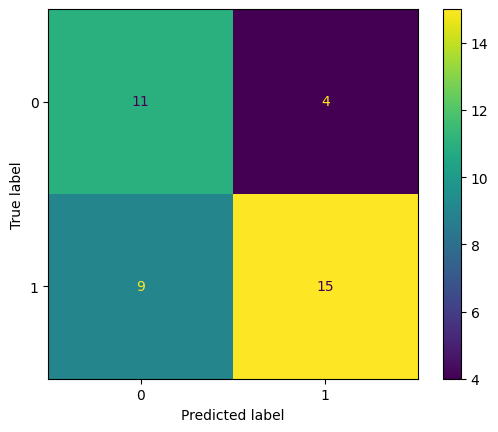

In [138]:
#media das pontuações de todos os cv
print("Media ",metricatxt," em todos os testes: ",grid.cv_results_['mean_test_score'].mean())

#mostrando matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_teste, previsao), display_labels = [0, 1])
cm_display.plot()
plt.show()

roc_auc_score em KNN:  0.6791666666666668


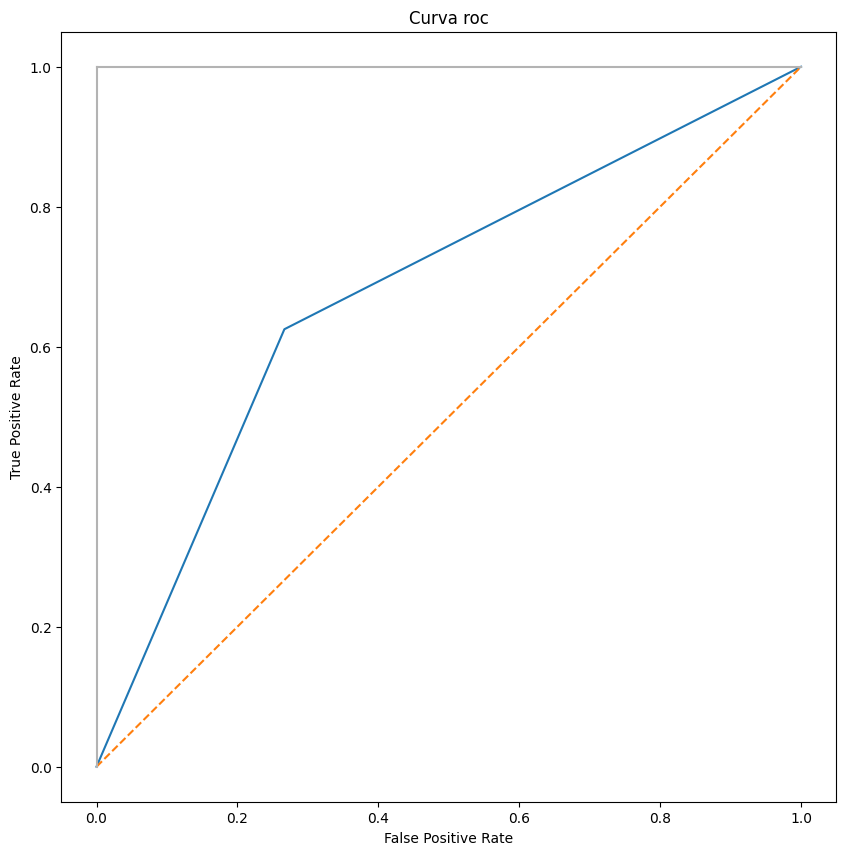

In [139]:
#mostrando o ROC score e a corva ROC

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, previsao)
print('roc_auc_score em KNN: ', roc_auc_score(y_teste, previsao))
plt.subplots(1, figsize=(10,10))
plt.title('Curva roc')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Treinando modelo com Decision Tree

#### Decision Tree com ccp_alpha

In [140]:
#Obtendo os ccp_alphas
classificador_tree = tree.DecisionTreeClassifier()

path = classificador_tree.cost_complexity_pruning_path(x_treino, y_treino)
cpp_alphas, impurities = path.ccp_alphas, path.impurities
print(cpp_alphas)
print(impurities)
cpp_alphas = cpp_alphas[:-1]

#treinando modelo com DecisionTree e CPP_ALPHA e analisando métricas resultantes
pipeline = Pipeline([
    ('pre1',pre1),
    ('dim',PCA()),
    ('model',tree.DecisionTreeClassifier())])


params_pipe = {
    'pre1__num__scaler': [StandardScaler(), MinMaxScaler()],
    'dim__n_components' : [1,2,3,4,5,6,7,None],
    'model__ccp_alpha':cpp_alphas
}


grid = GridSearchCV(estimator=pipeline,param_grid = params_pipe, n_jobs=-1, scoring=metrica)

grid.fit(x_treino,y_treino)

[0.         0.0016129  0.00215054 0.00301075 0.00322581 0.0047491
 0.00483871 0.00580645 0.00619355 0.00650675 0.00703812 0.00791789
 0.00860215 0.00860215 0.00921659 0.00947624 0.00967742 0.01032542
 0.01143424 0.01207373 0.0124005  0.01384917 0.01602615 0.01824168
 0.05008936]
[0.01935484 0.02258065 0.02473118 0.02774194 0.03096774 0.04996416
 0.069319   0.0925448  0.1049319  0.11794541 0.13905978 0.14697767
 0.15557982 0.18138627 0.19981945 0.21877193 0.22844935 0.26975102
 0.28118527 0.30533273 0.34253424 0.39793093 0.42998322 0.44822489
 0.49831426]


GridSearchCV(estimator=Pipeline(steps=[('pre1',
                                        ColumnTransformer(transformers=[('num',
                                                                         ScalerSelector(),
                                                                         ['Qual '
                                                                          'é '
                                                                          'seu '
                                                                          'genero?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'sua '
                                                                          'idade?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'média '
                                                                          'da '
                                                                          'sua '
                                                                          'renda '
                                                                          'familiar '
                                                                          'mensal?',
                                                                          'Qual '
                                                                          'estado '
                                                                          'você '
                                                                          'mora?',
                                                                          'Você '
                                                                          'usa '
                                                                          'muitos '
                                                                          'eletrônicos '
                                                                          'durante '
                                                                          'o '
                                                                          'dia? '
                                                                          '(6h '
                                                                          'ou '
                                                                          'mais)',
                                                                          'Qual '
                                                                          'grau '
                                                                          'de '
                                                                          'educação '
                                                                          'você '
                                                                          'tem?',
                                                                          'Você '
                                                                          'prat...
             param_grid={'dim__n_components': [1, 2, 3, 4, 5, 6, 7, None],
                         'model__ccp_alpha': array([0.        , 0.0016129 , 0.00215054, 0.00301075, 0.00322581,
       0.0047491 , 0.00483871, 0.00580645, 0.00619355, 0.00650675,
       0.00703812, 0.00791789, 0.00860215, 0.00860215, 0.00921659,
       0.00947624, 0.00967742, 0.01032542, 0.01143424, 0.01207373,
       0.0124005 , 0.01384917, 0.01602615, 0.01824168]),
                         'pre1__num__scaler': [StandardScaler(),
                                               MinMaxScaler()]},
             scoring='f1')

In [141]:
#mostrando melhores parametros, classification report e recall do modelo, prestando atenção especialmente no recall pois é o mais vantajoso para nosso caso
melhor = grid.best_params_
classificador_grafico = grid.best_estimator_ 
print("Melhores parametros: ",melhor)
print("Melhor ",metricatxt,": ",grid.best_score_)
previsao = classificador_grafico.predict(x_teste)
print(classification_report(y_teste,previsao))

Melhores parametros:  {'dim__n_components': 7, 'model__ccp_alpha': 0.011434243176178653, 'pre1__num__scaler': MinMaxScaler()}
Melhor  f1 score :  0.6240817029815263
              precision    recall  f1-score   support

           0       0.50      0.73      0.59        15
           1       0.76      0.54      0.63        24

    accuracy                           0.62        39
   macro avg       0.63      0.64      0.61        39
weighted avg       0.66      0.62      0.62        39



Media  f1 score  em todos os testes:  0.5255384195002593


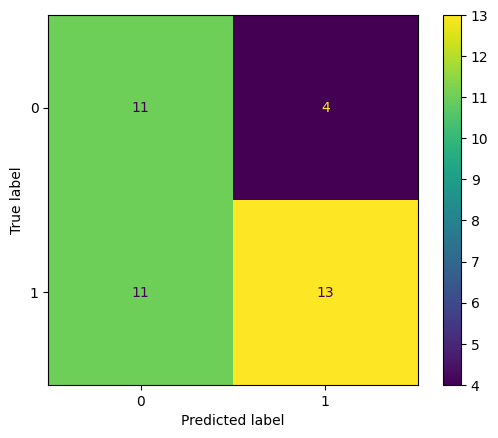

In [142]:
#media das pontuações de todos os cv
print("Media ",metricatxt," em todos os testes: ",grid.cv_results_['mean_test_score'].mean())

#mostrando matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_teste, previsao), display_labels = [0, 1])
cm_display.plot()
plt.show()

roc_auc_score em DecisionTree com ccp alpha:  0.6375


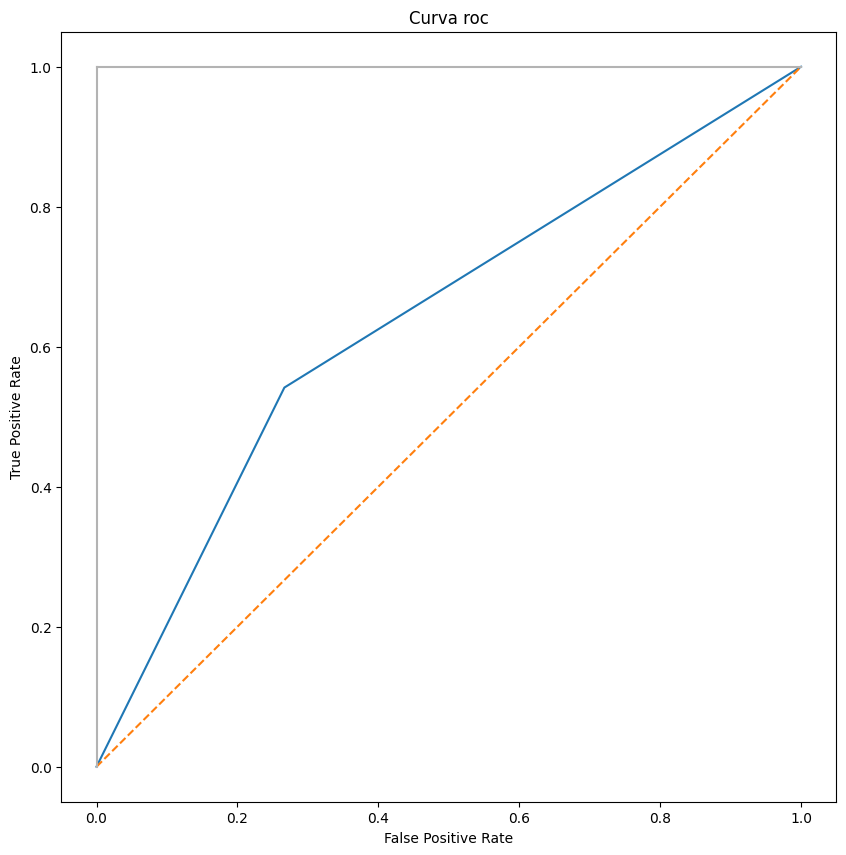

In [143]:
#mostrando o ROC score e a corva ROC

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, previsao)
print('roc_auc_score em DecisionTree com ccp alpha: ', roc_auc_score(y_teste, previsao))
plt.subplots(1, figsize=(10,10))
plt.title('Curva roc')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Text(0.5104166666666666, 0.95, 'x[1] <= 0.298\ngini = 0.498\nsamples = 155\nvalue = [82, 73]'),
 Text(0.2708333333333333, 0.85, 'x[5] <= -0.296\ngini = 0.434\nsamples = 88\nvalue = [60.0, 28.0]'),
 Text(0.390625, 0.8999999999999999, 'True  '),
 Text(0.08333333333333333, 0.75, 'x[1] <= -0.663\ngini = 0.459\nsamples = 14\nvalue = [5, 9]'),
 Text(0.041666666666666664, 0.65, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.125, 0.65, 'x[1] <= -0.377\ngini = 0.494\nsamples = 9\nvalue = [5, 4]'),
 Text(0.08333333333333333, 0.55, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.16666666666666666, 0.55, 'x[5] <= -0.387\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(0.125, 0.45, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.20833333333333334, 0.45, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.4583333333333333, 0.75, 'x[2] <= 0.777\ngini = 0.382\nsamples = 74\nvalue = [55, 19]'),
 Text(0.375, 0.65, 'x[2] <= 0.085\ngini = 0.308\nsamples = 63\nvalue = [51, 12]'),
 Text(0.3

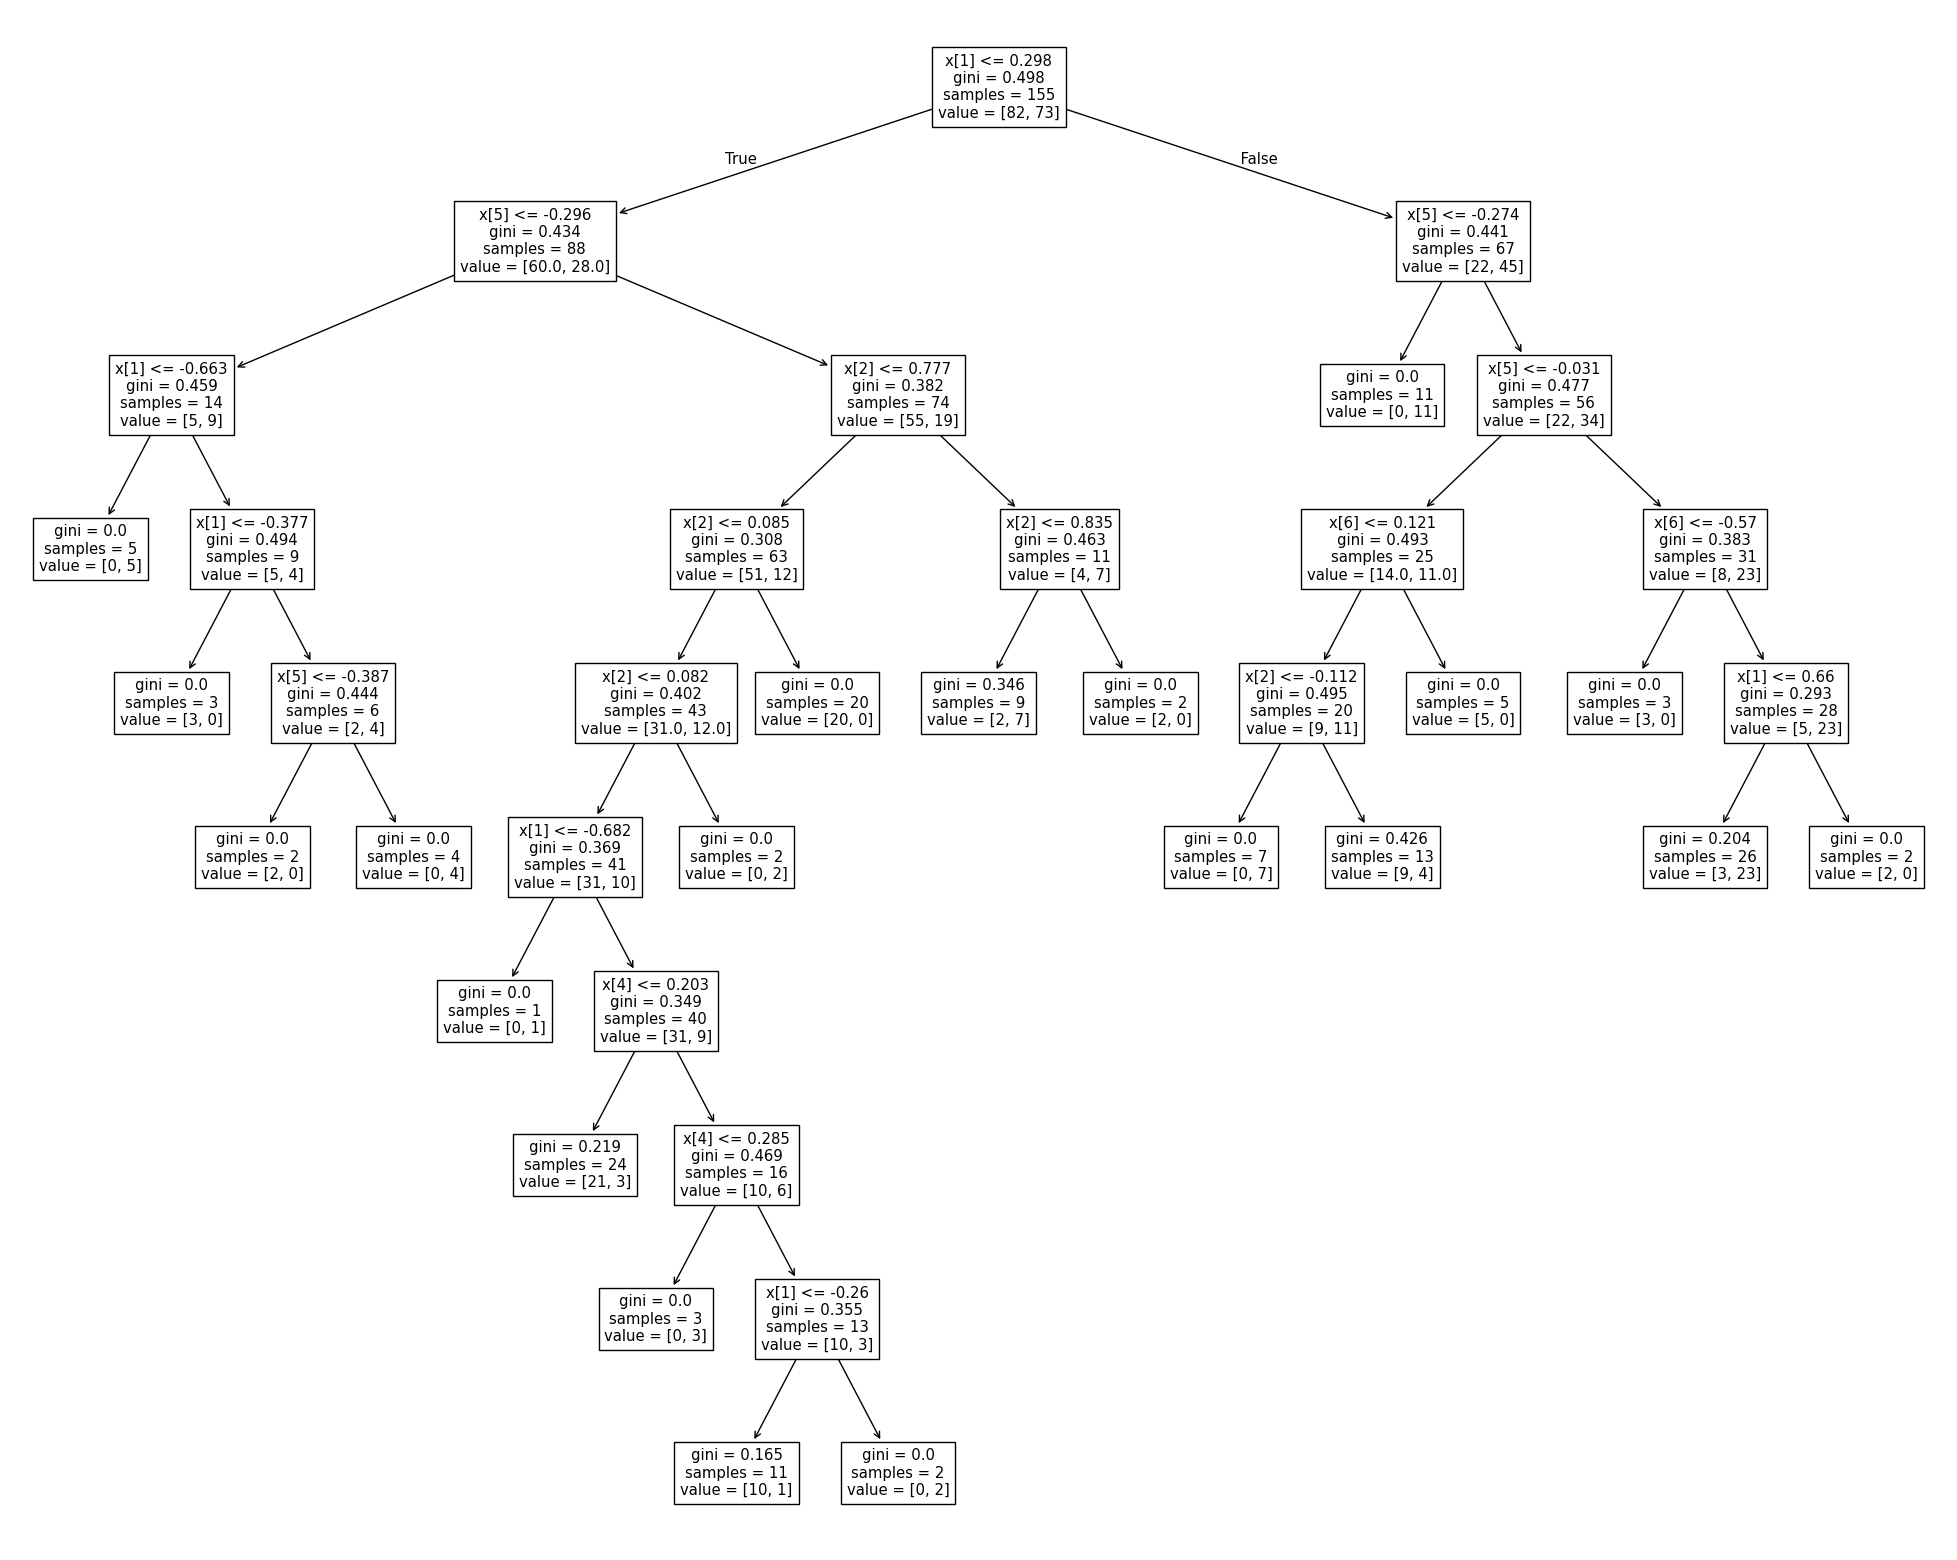

In [144]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(classificador_grafico['model'])

#### Decision Tree com hyperparametros

In [145]:
#treinando modelo com DecisionTree e hyperparametros e analisando métricas resultantes
pipeline = Pipeline([
    ('pre1',pre1),
    ('dim',PCA()),
    ('model',tree.DecisionTreeClassifier())])


params_pipe = {
    'pre1__num__scaler': [StandardScaler(), MinMaxScaler()],
    'dim__n_components' : [1,2,3,4,5,6,7,None],
    'model__criterion': ['gini','entropy','log_loss'],
    'model__splitter': ['best','random'],
    'model__max_depth': [None,2,4,6,8,10,12],
    'model__min_samples_split': [2,4,6,8,10],
    'model__min_samples_leaf': [1,2,4,6,8,10],
    'model__max_features':[None,'sqrt','log2']
}


grid = GridSearchCV(estimator=pipeline,param_grid = params_pipe, n_jobs=-1, scoring=metrica)

grid.fit(x_treino,y_treino)

GridSearchCV(estimator=Pipeline(steps=[('pre1',
                                        ColumnTransformer(transformers=[('num',
                                                                         ScalerSelector(),
                                                                         ['Qual '
                                                                          'é '
                                                                          'seu '
                                                                          'genero?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'sua '
                                                                          'idade?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'média '
                                                                          'da '
                                                                          'sua '
                                                                          'renda '
                                                                          'familiar '
                                                                          'mensal?',
                                                                          'Qual '
                                                                          'estado '
                                                                          'você '
                                                                          'mora?',
                                                                          'Você '
                                                                          'usa '
                                                                          'muitos '
                                                                          'eletrônicos '
                                                                          'durante '
                                                                          'o '
                                                                          'dia? '
                                                                          '(6h '
                                                                          'ou '
                                                                          'mais)',
                                                                          'Qual '
                                                                          'grau '
                                                                          'de '
                                                                          'educação '
                                                                          'você '
                                                                          'tem?',
                                                                          'Você '
                                                                          'prat...
             param_grid={'dim__n_components': [1, 2, 3, 4, 5, 6, 7, None],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [None, 2, 4, 6, 8, 10, 12],
                         'model__max_features': [None, 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'model__min_samples_split': [2, 4, 6, 8, 10],
                         'model__splitter': ['best', 'random'],
                         'pre1__num__scaler': [StandardScaler(),
                                               MinMaxScaler()]},
             

In [146]:
#mostrando melhores parametros, classification report e recall do modelo, prestando atenção especialmente no recall pois é o mais vantajoso para nosso caso
melhor = grid.best_params_
classificador_grafico = grid.best_estimator_ 
print("Melhores parametros: ",melhor)
print("Melhor ",metricatxt,": ",grid.best_score_)
previsao = classificador_grafico.predict(x_teste)
print(classification_report(y_teste,previsao))

Melhores parametros:  {'dim__n_components': 6, 'model__criterion': 'entropy', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__splitter': 'random', 'pre1__num__scaler': StandardScaler()}
Melhor  f1 score :  0.6770518207282913
              precision    recall  f1-score   support

           0       0.42      0.53      0.47        15
           1       0.65      0.54      0.59        24

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.53        39
weighted avg       0.56      0.54      0.54        39



Media  f1 score  em todos os testes:  0.47084482933188604


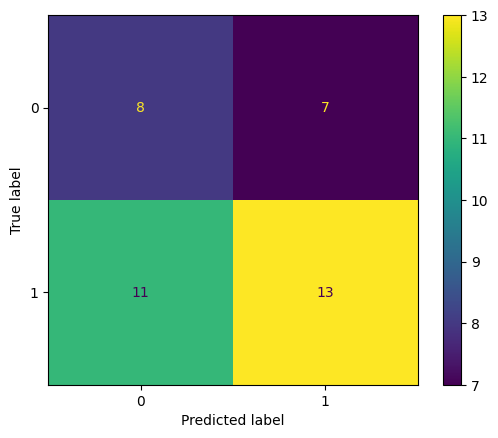

In [147]:
#media das pontuações de todos os cv
print("Media ",metricatxt," em todos os testes: ",grid.cv_results_['mean_test_score'].mean())

#mostrando matriz de confusão
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_teste, previsao), display_labels = [0, 1])
cm_display.plot()
plt.show()

roc_auc_score em DecisionTree com hyperparametros:  0.5374999999999999


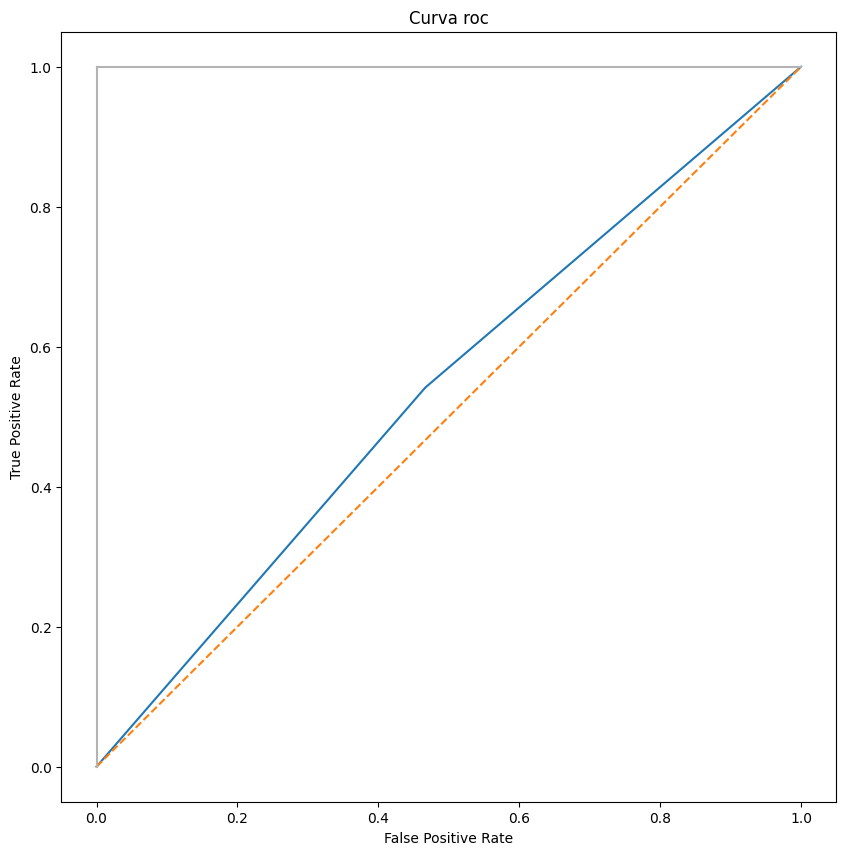

In [148]:
#mostrando o ROC score e a corva ROC

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, previsao)
print('roc_auc_score em DecisionTree com hyperparametros: ', roc_auc_score(y_teste, previsao))
plt.subplots(1, figsize=(10,10))
plt.title('Curva roc')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

[Text(0.4403409090909091, 0.9545454545454546, 'x[3] <= -1.632\nentropy = 0.998\nsamples = 155\nvalue = [82, 73]'),
 Text(0.09090909090909091, 0.8636363636363636, 'x[5] <= 2.664\nentropy = 0.845\nsamples = 11\nvalue = [8, 3]'),
 Text(0.265625, 0.9090909090909092, 'True  '),
 Text(0.07272727272727272, 0.7727272727272727, 'x[5] <= 0.805\nentropy = 0.722\nsamples = 10\nvalue = [8, 2]'),
 Text(0.05454545454545454, 0.6818181818181818, 'x[0] <= 0.432\nentropy = 0.811\nsamples = 8\nvalue = [6, 2]'),
 Text(0.03636363636363636, 0.5909090909090909, 'x[0] <= -1.418\nentropy = 0.863\nsamples = 7\nvalue = [5, 2]'),
 Text(0.01818181818181818, 0.5, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.05454545454545454, 0.5, 'x[3] <= -2.48\nentropy = 0.918\nsamples = 6\nvalue = [4, 2]'),
 Text(0.03636363636363636, 0.4090909090909091, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.07272727272727272, 0.4090909090909091, 'x[0] <= -0.583\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]'),
 Text(0.0545

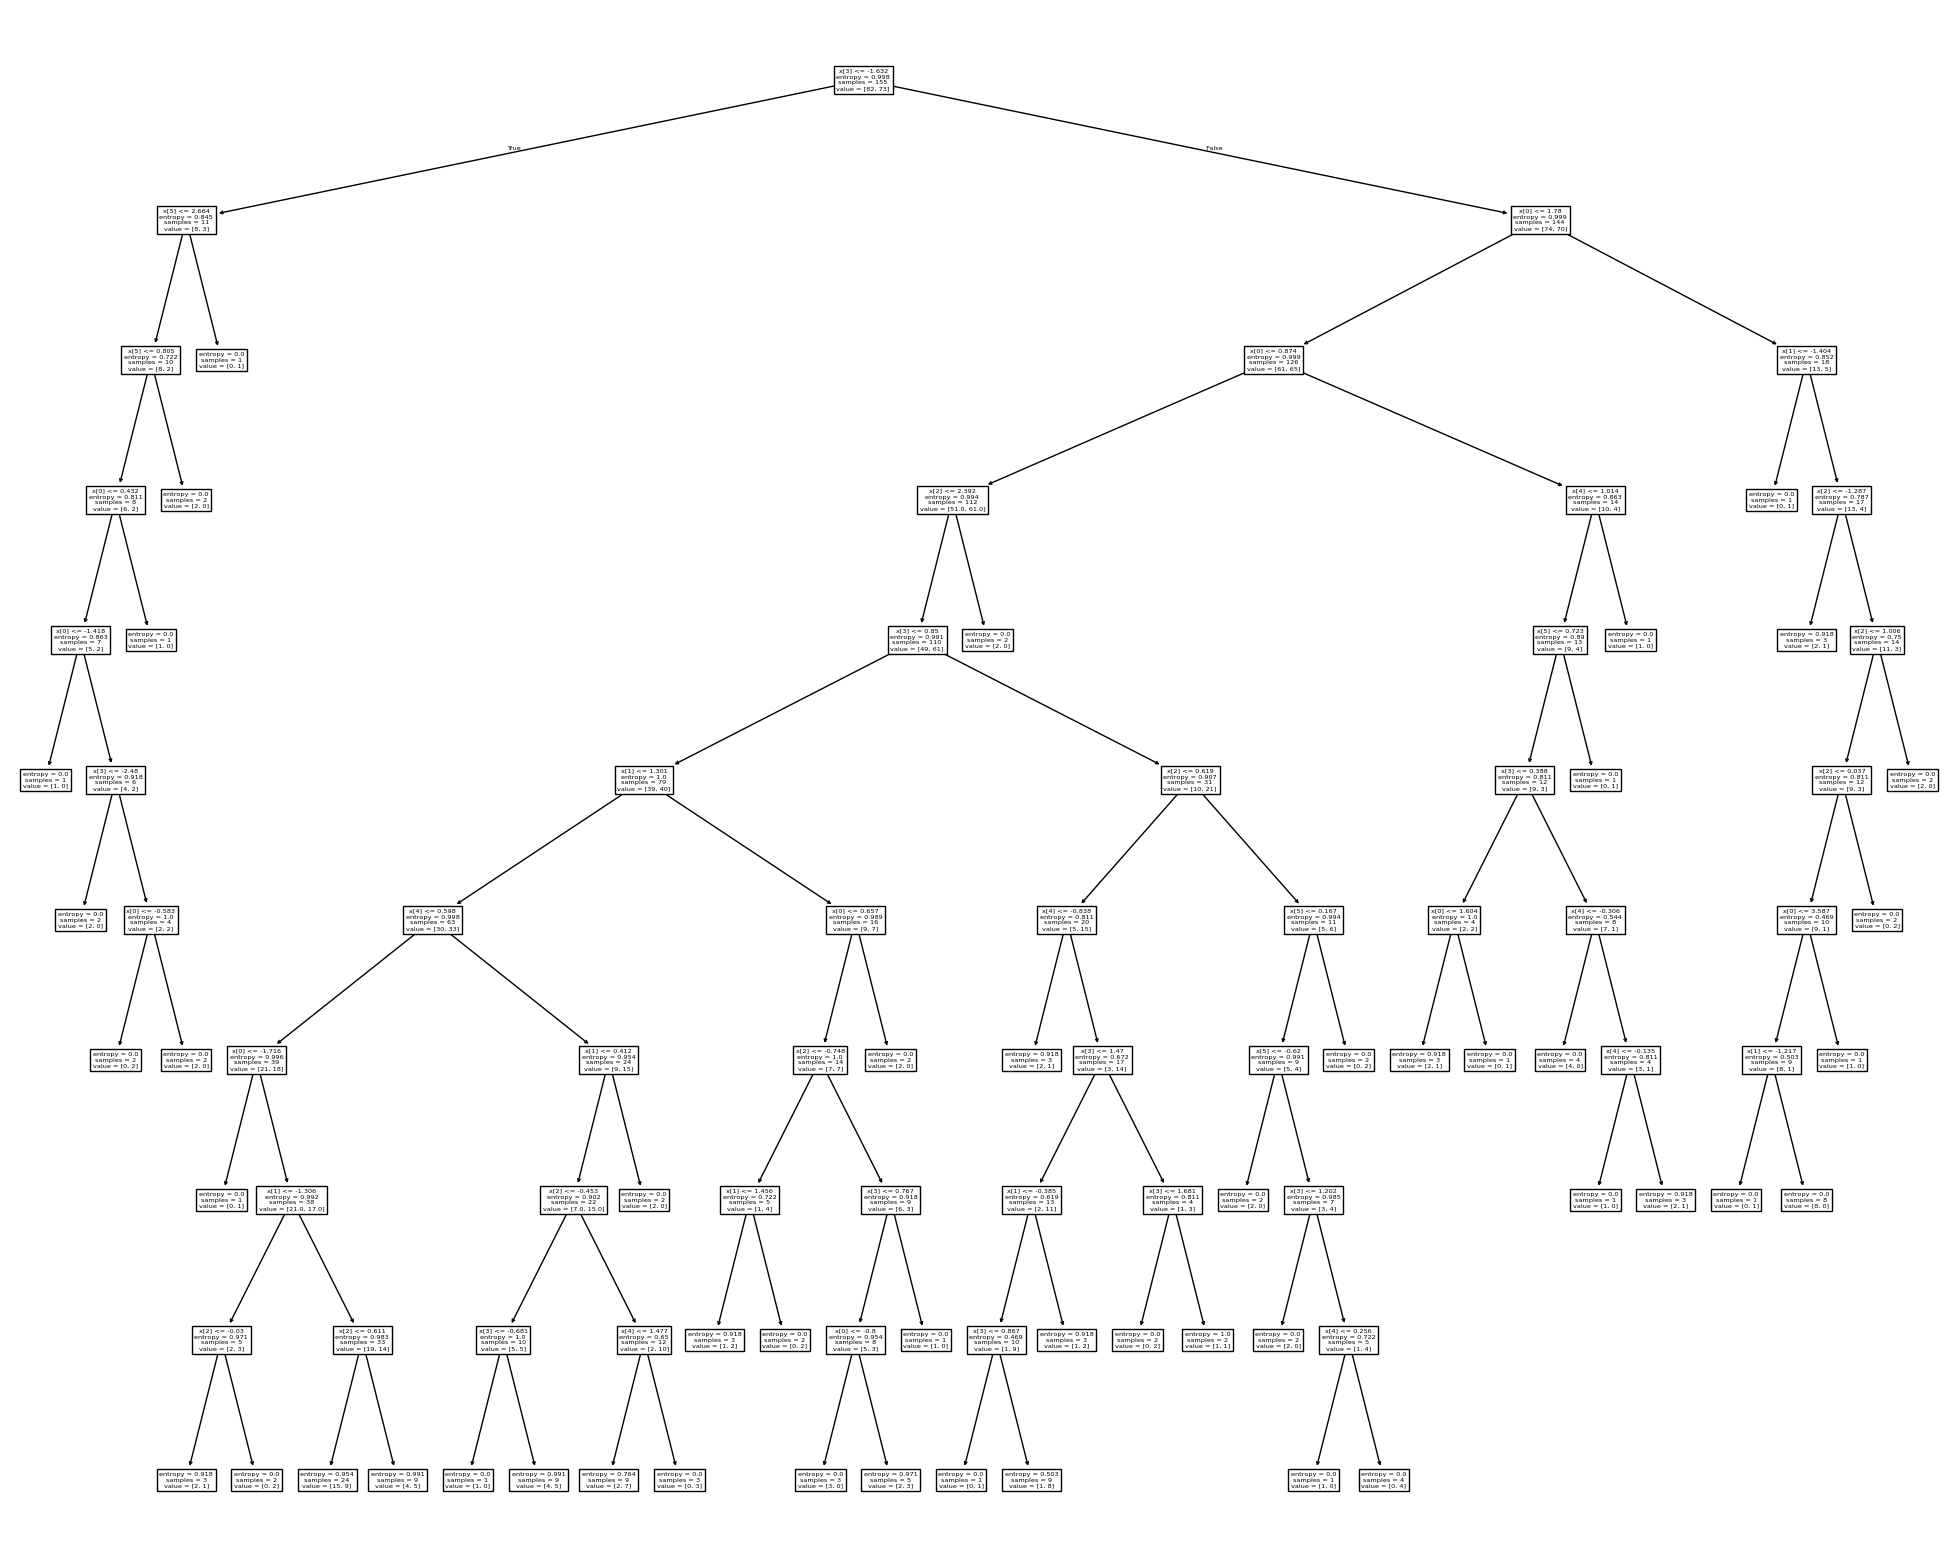

In [149]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(classificador_grafico['model'])

## Treinando modelo com SVC

In [150]:
print(rseed)
pipeline = Pipeline([
    ('pre1',pre1),
    ('dim',PCA()),
    ('model',SVC())])


params_pipe = {
    'pre1__num__scaler': [StandardScaler(), MinMaxScaler()],
    'dim__n_components' : [2,3,4,5,6,7,None],
    'model__kernel' : ['poly', 'rbf', 'sigmoid'],
    'model__C':np.arange(0.1,10,0.1),
    'model__gamma': ['scale','auto'],
    'model__shrinking': [True,False],
    'model__probability': [True,False],
}


grid = GridSearchCV(estimator=pipeline,param_grid = params_pipe, n_jobs=-1, scoring=metrica)

grid.fit(x_treino,y_treino)

517398857


GridSearchCV(estimator=Pipeline(steps=[('pre1',
                                        ColumnTransformer(transformers=[('num',
                                                                         ScalerSelector(),
                                                                         ['Qual '
                                                                          'é '
                                                                          'seu '
                                                                          'genero?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'sua '
                                                                          'idade?',
                                                                          'Qual '
                                                                          'é a '
                                                                          'média '
                                                                          'da '
                                                                          'sua '
                                                                          'renda '
                                                                          'familiar '
                                                                          'mensal?',
                                                                          'Qual '
                                                                          'estado '
                                                                          'você '
                                                                          'mora?',
                                                                          'Você '
                                                                          'usa '
                                                                          'muitos '
                                                                          'eletrônicos '
                                                                          'durante '
                                                                          'o '
                                                                          'dia? '
                                                                          '(6h '
                                                                          'ou '
                                                                          'mais)',
                                                                          'Qual '
                                                                          'grau '
                                                                          'de '
                                                                          'educação '
                                                                          'você '
                                                                          'tem?',
                                                                          'Você '
                                                                          'prat...
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['poly', 'rbf', 'sigmoid'],
                         'model__probability': [True, False],
                         'model__shrinking': [True, False],
                         'pre1__num__scaler': [StandardScaler(),
                                               MinMaxScaler()]},
  

In [151]:
melhor = grid.best_params_
classificador_grafico = grid.best_estimator_ 

print("Melhores parametros: ",melhor)
print("Melhor ",metricatxt,": ",grid.best_score_)
previsao = classificador_grafico.predict(x_teste)
print(classification_report(y_teste,previsao))

Melhores parametros:  {'dim__n_components': None, 'model__C': 1.3000000000000003, 'model__gamma': 'scale', 'model__kernel': 'sigmoid', 'model__probability': True, 'model__shrinking': True, 'pre1__num__scaler': MinMaxScaler()}
Melhor  f1 score :  0.6836996336996337
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.82      0.75      0.78        24

    accuracy                           0.74        39
   macro avg       0.73      0.74      0.74        39
weighted avg       0.75      0.74      0.75        39



0.5151926692214268

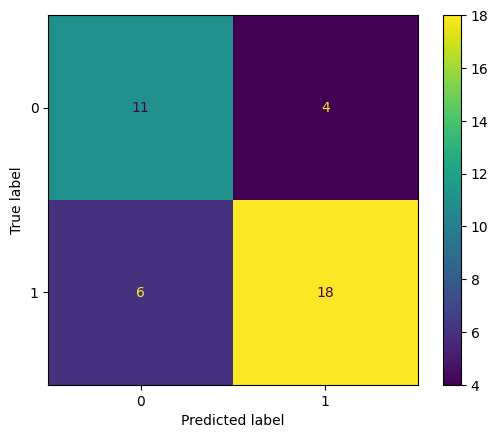

In [152]:
display(grid.cv_results_['mean_test_score'].mean())

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_teste, previsao), display_labels = [0, 1])
cm_display.plot()
plt.show()

roc_auc_score em SVC:  0.7416666666666667


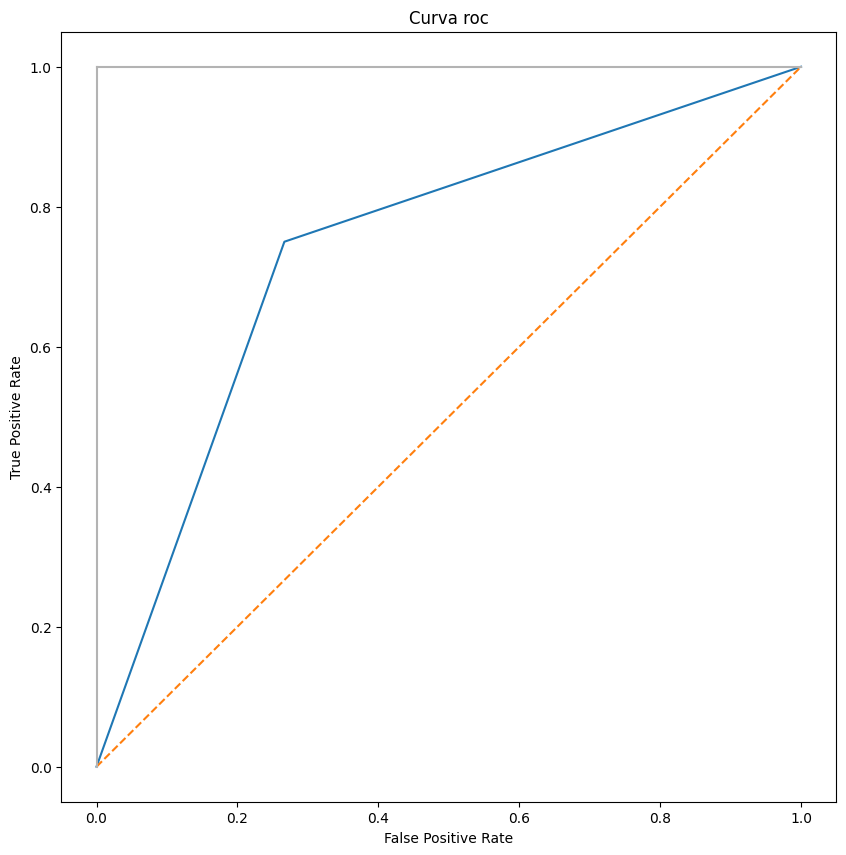

In [153]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_teste, previsao)
print('roc_auc_score em SVC: ', roc_auc_score(y_teste, previsao))
plt.subplots(1, figsize=(10,10))
plt.title('Curva roc')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusões

#### Após analizar as métricas de todos os modelos, nós julgamos que a melhor escolha fosse usar o SVC.